Yaqin Huang

Edited by Mohamed Sayed on 27/11/2019. All errors are now my own.
# Practical 7 - Part 1A

The aim of part 1A is to calculate the homography that best maps two sets of points to one another.  We will (eventually) use this for creating panoramas, and for calculating the 3D pose of planes.  You should use this
template for your code and fill in the missing sections marked "TO DO"


## Import libraries 

In [1]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

## Test case formulation

To start with, let's set up some start points `pts1Cart` and a homography, `H`, that we can use to generate target points `pts2Cart`. We'll also add some noise to `pts2Cart` to simulate a real world environment. The challenge is to find the same homography, or as close as noise allows, given `pts1Cart` and `pts2Cart`.

__NOTE:__ It may be helpful to set `noiseLevel` to 0 to start with so that you can check if your solution is spot on while debugging. Make sure you set it back to some value, here we use 4, when you're confident your solution works.

In [2]:
# Define a set of two-dimensional Cartesian points
pts1Cart = np.array([[240.5000, 16.8351, 33.5890, 164.2696, 149.1911],
                    [248.8770, 193.5890, 251.3901, 168.4581, 228.7723]])

# Convert points into homogeneous representation
pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)

# Define a homography
H = np.array([[0.6, 0.7, -100.],
              [1.0, 0.6, 50.],
              [0.001, 0.002, 1.0]])

# Apply a homography to the points
pts2Hom = np.matmul(H,pts1Hom)

# Convert back to Cartesian coordinates
pts2Cart = pts2Hom[0:2,:] / np.tile([pts2Hom[2,:]],(2,1))

# Add a small amount of noise. Set this to zero to begin with to see if your homography solution is spot on.
noiseLevel = 4.0
pts2Cart = pts2Cart + np.random.normal(0, noiseLevel, pts2Cart.shape)

## Plotting

Let's plot the the first original set of points, `pts1Cart`, in blue and the second set of points, `pts2Cart`, in red. 

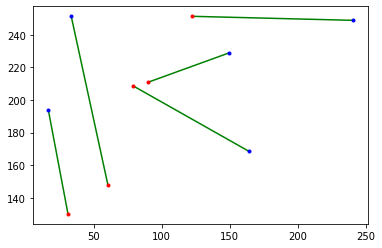

In [3]:
# Plot a green line between pairs of start points (blue) and transformed points (red).|
nPoint = pts1Cart.shape[1]
for cPoint in range(0, nPoint):
    plt.plot([pts1Cart[0,cPoint], pts2Cart[0,cPoint]], [pts1Cart[1,cPoint], pts2Cart[1,cPoint]],'g-')
    plt.plot(pts1Cart[0,cPoint],pts1Cart[1,cPoint],'b.', pts2Cart[0,cPoint],pts2Cart[1,cPoint],'r.') 

plt.show()

Explaination:We have 5 pairs of start points  drwan in blue and 5 pairs of target points drawn in red. This graphs shows the change of points after we apply the homography H. 
However, since we add a small amount of noise to the target points, when we use the start point and the target points with noise to find our homography, we may not get the exactly correct one. Instead if we set the noise to zero, we will get the same homography we apply before.  

## Homography estimation time!

We've formulated our test example; now our goal is to estimate the homography that maps the first set of points to the second set of points.

### ****TO DO****: Fill in the details of these routines (solveAXEqualsZero and calcBestHomography). 

In [4]:
def solveAXEqualsZero(A):
    # TO DO: Write this routine - it should solve Ah = 0. You can do this using SVD. Consult your notes! 
    # Hint: SVD will be involved. 
    U,L,Vt = np.linalg.svd(A)
    #we will get V^T from svd(A)
    V = Vt.T
    #h is the last column of our V.
    h = V[:,-1]
    return h

In [5]:
def calcBestHomography(pts1Cart, pts2Cart):
    
    # This function should apply the direct linear transform (DLT) algorithm to calculate the best 
    # homography that maps the cartesian points in pts1Cart to their corresonding matching cartesian poitns 
    # in pts2Cart.
    
    # This function calls solveAXEqualsZero. Make sure you are wary of how to reshape h into a 3 by 3 matrix. 

    n_points = pts1Cart.shape[1]
    
    # TO DO: replace this:
    H = np.identity(3)
    
 

    # TO DO: 
    # First convert points into homogeneous representation
    # Hint: we've done this before  in the skeleton code we provide.
    pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)
    pts2Hom = np.concatenate((pts2Cart, np.ones((1,pts2Cart.shape[1]))), axis=0)
    
    # Then construct the matrix A, size (n_points * 2, 9)
    A = np.zeros((n_points * 2,9))
    
    # Consult the notes!
    #The matrix is given by slide 27 from chapter 15.
    for i in range(n_points):
        UV = pts1Hom[:,i]
        u = UV[0]
        v = UV[1]
        XY = pts2Hom[:,i]
        x = XY[0]
        y = XY[1]
        
        A[2 * i,:] = [0,0,0,-u,-v,-1,y*u,y*v,y]
        
        A[2 * i+1,:] = [u,v,1,0,0,0,-x*u,-x*v,-x]
    
    
    # Solve Ah = 0 using solveAXEqualsZero and get h.
    h = solveAXEqualsZero(A)
    # Reshape h into the matrix H, values of h go first into rows of H
    H = np.reshape(h,(3, 3))

    
    return H

## Test time!

Time to put it all together. 

Now we need a way of measuring how well our mapping does. To do this we will apply our estimated mapping, `HEst`, to `pts1Cart` and obtain estimated points `pts2EstCart`. We will compare `pts2EstCart` and `pts2Cart` using a sum of squared difference to see how well our solution at least approximates the transformed noisy points `pts2Cart`.

Red points on the plot are the noisy points we observe, `pts2Cart`, and the magenta points are the transformed points, `pts2EstCart`, that we get when we apply our estimated homography on `pts1Cart`. The black lines represent the error between both points; if you've set `noiseLevel` to 0, then `sqDiff` should be 0 and the points should overlap perfectly.

Sqaured difference between pts2Cart and pts2EstCart is: 1.83


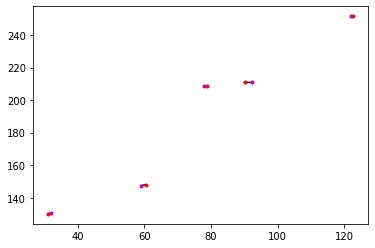

In [6]:
# Replace this with a call to the function calcBestHomography. You'll need to figure out which way around the 
# points go in the function, i.e. which direction this homography transforms points from and to. The ordering 
# is dead simple for now but acts as a simple exercise for what comes in later parts of this practical.
HEst = 100.00*calcBestHomography(pts1Cart, pts2Cart)

# Apply estimated homography to points
pts2EstHom = np.matmul(HEst,pts1Hom)

# Convert back to Cartesian coordinates
pts2EstCart = pts2EstHom[0:2,:] / np.tile([pts2EstHom[2,:]],(2,1))

# Calculate the mean squared distance from actual points
sqDiff = np.mean(sum((pts2Cart - pts2EstCart)**2))

print("Sqaured difference between pts2Cart and pts2EstCart is: %.2f" % sqDiff)

# Draw figure with points before and after applying the estimated homography
nPoint = pts1Cart.shape[1]

# Plot a black line between pairs of actual points (red) and estimated points (magenta)
for cPoint in range(0, nPoint):
    plt.plot([pts2Cart[0,cPoint], pts2EstCart[0,cPoint]], [pts2Cart[1,cPoint], pts2EstCart[1,cPoint]],'k-')
    plt.plot(pts2Cart[0,cPoint],pts2Cart[1,cPoint],'r.',pts2EstCart[0,cPoint],pts2EstCart[1,cPoint],'m.') 

plt.show()

Explaination: This graph demonstrate the difference between the pts2Cart(red points) and pts2EstCart(magenta points). The pts2Cart are the noisy points we compute by the real homography.The pts2EstCart are the points we computed by applying the estimate homography on the pts1Cart. If we set the noisy to be zero, then we will get the same points and the difference between two sets of points is zero.

## Other things **** TO DO ****

1: Convince yourself that the homography is ambiguous up to scale (by
multiplying it by a constant factor and showing it does the same thing).
Can you see why this is the case mathematically?

2: Show empirically that your homography routine can EXACTLY map any four points to any
other four points.

1.If we multiply a const c to our homography system. 
$c
       \begin{bmatrix}
       \phi_{11} &; \phi_{12} &; \phi_{13}\\ 
       \phi_{21} &; \phi_{22} &; \phi_{23}\\ 
       \phi_{31} &; \phi_{32} &; \phi_{33}
       \end{bmatrix}
       \begin{bmatrix}
        u\\ 
        v\\ 
        1
       \end{bmatrix}
       = c\lambda \begin{bmatrix}
        x\\ 
        y\\ 
        1
       \end{bmatrix}
       $
Since we use the homogeneous coordinates system, after the matrix computation, we need convert our homogeneous coordinates back to the Cartesian coordinates, we need divide the $c\lambda$. Even though we multiply some constant, we wiil divide the same number to convert back to the Cartesian coordinates.
Therefore, the homography is ambiguous to scale.

2.Notice, the Homography matrix is a 3*3 matrix, so we have 9 unknowns. However, we set our last unknow to be 1. In this cases, we have 8 unknowns and  to solve 8 unknows we need at least 8 equations.By constructing our system, 4 corresponds(4 points) points will give us 8 equations.The noise will have effect on the svd computation, which is the case we have more equations than unknows. If we only have four points, then we can get exactly 8 equations to solve 8 unknows. The noise won't have any effect when we solve the linear system. Therefore we can exactly map any four points to any other four points, no matter how much the noise we add, we always get zero difference.